In [ ]:
import pandas as pd 
import numpy as np
from scipy import linalg, stats

import matplotlib.pyplot as plt

import mahalanobis as maha

#### Read the dataset

In [3]:
df = pd.read_parquet('data/covid_confirm.parquet')

#### Define the functions to perform whitening and compute Mahalanobis distance

**Whitening** is a transformation that takes the distribution of Healthy cells and maps them to such space that
1. has orthogonal directions – each feature is uncorrelated with others,
2. these directions span the most of the covariance – they capture the scattering of Healthy cells best,
3. new space has lower dimension - we can drop those orthogonal directions that span too little information (same as in PCA),
4. orthogonal directions are standartized – the scattering of Healthy cells becomes uniform along each direction; hence each feauture impacts our distance equally.

**Mahalanobis distance** = Ordinary Euclidean distance computed after whitening transformation

#### Selecting effective dimension

(by looking at the singular values from PCA)

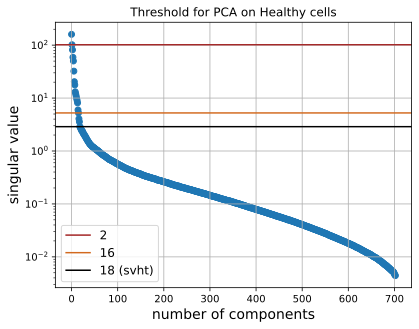

In [4]:
df_healthy = df[df['batch_id'] == 'non-inf']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()

cov_matrix = np.cov(x_healthy, rowvar=False)
sigma, u = linalg.eigh(cov_matrix, check_finite=True)
rank = min(*x_healthy.shape) - 1
sigma = sigma[::-1]
plt.scatter(range(rank), sigma[:rank])

n_components = 2
plt.axhline(sigma[n_components - 1], c='brown', label=n_components)

n_components = np.count_nonzero(sigma > 5)
plt.axhline(sigma[n_components - 1], c='chocolate', label=n_components)

# optimal threshold for PCA of Healthy cells
tau = maha.svht(x_healthy)
plt.axhline(sigma[int(tau)], c='k', label=f'{int(tau)} (svht)')

plt.grid()
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('number of components', fontsize=14)
plt.ylabel('singular value', fontsize=14)
plt.title("Threshold for PCA on Healthy cells")
plt.show()

#### Whitening and Mahalanobis distance

In [5]:
# Predictions based on whitening transform
n_components = 18

# Distance to Healthy (Mahalanobis)
x_all = df.iloc[:, 7:].copy()
# clip = 50
# x_all.clip(lower=-clip, upper=clip, inplace=True)

df_healthy = df[df['batch_id'] == 'non-inf']
x_healthy = df_healthy.iloc[:, 7:].to_numpy()
dist_pred = maha.get_distance(x_healthy, x_all, n_components=n_components)
dist_pred = pd.DataFrame(dist_pred, columns=['distance'])

# Probability of Healthy
proba_pred = maha.get_proba(x_healthy, x_all, n_components=n_components)
proba_pred = pd.DataFrame(proba_pred, columns=['proba'])

#### Concatenate predictions


In [6]:
predictions = pd.concat([df.iloc[:, :7], dist_pred, proba_pred], axis=1)

Use the separate file that maps `batch_id` to the name of each drug

In [7]:
with open("data/id_to_name.txt", 'r') as file:
    table = file.readlines()

id_to_name = {}
for i, line in enumerate(table):
    id_, name = line.rstrip().split('\t')
    id_to_name[id_] = name

#### Ranking all compounds by distance

Rows in the ranking below correspond to different compounds at different concentrations, i.e., we average over replicates.

In [10]:
def quantile(n):
    def quantile_(x):
        return x.quantile(n)
    quantile_.__name__ = f'q_{n*100:.0f}'
    return quantile_

selected_columns = predictions[[
    'batch_id', 
    'cmpd_conc',
    'Count_nuclei', 
    'distance',
    # 'proba',
]].copy()

selected_columns['name'] = selected_columns['batch_id'].map(id_to_name)

# Aggregate replicates
average_predictions = selected_columns.groupby(by=['batch_id', 'name', 'cmpd_conc'], as_index=False).agg({
        'Count_nuclei': 'median', 
        'distance': [quantile(.25), quantile(.75), 'median'],
        # 'proba': 'median',
})
# Rename columns
custom_columns = [''.join(col) for col in average_predictions.columns.to_flat_index() if not col[1]]
custom_columns += ['_'.join(col) for col in average_predictions.columns.to_flat_index() if col[1]]
average_predictions.columns = custom_columns

# Sort by distance to non-infected
average_predictions.sort_values(by=['distance_median'], ascending=True, inplace=True)

# Quantiles are written as plus/minus to the median
average_predictions['distance_q_75'] = average_predictions['distance_q_75'] - average_predictions['distance_median']
average_predictions['distance_q_25'] =  average_predictions['distance_median'] - average_predictions['distance_q_25']

average_predictions.reset_index(inplace=True, drop=True)

**Note**: after the whitening, the squared distance is distributed as a chi-squared random variable – $\chi^2_d$, where $d$ is the selected effective dimension. We can use to test compunds against confidence intervals of this distribution.

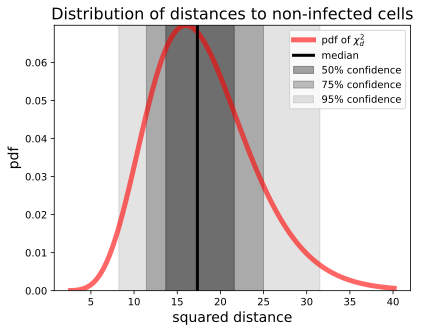

In [11]:
x = np.linspace(stats.chi2.ppf(1e-5, df=n_components), stats.chi2.ppf(1-2e-3, df=n_components), 100)
pdf = stats.chi2.pdf(x, df=n_components)
plt.plot(x, pdf, 'r-', lw=5, alpha=0.6, label=r'$\text{pdf of } \chi^2_d$')
plt.axvline(stats.chi2.median(df=n_components), label='median', c='k', lw=3)
for conf in (0.5, 0.75, 0.95):
    left, right = stats.chi2.interval(conf, df=n_components)
    plt.fill_betweenx(y=np.linspace(-1, 0.1, 2), x1=left, x2=right, label=f'{conf*100:.0f}% confidence',
                      color='k', alpha=0.5*(1-conf)**0.5)
plt.legend()
plt.ylim(0, max(pdf))
plt.xlabel("squared distance", fontsize=14)
plt.ylabel("pdf", fontsize=14)
plt.title("Distribution of distances to non-infected cells",  fontsize=16)
plt.show()

Hence, we can rank drugs based on the following: does the distance from a treated cell to an average healthy cell fall into the confidence interval? Furthermore, we can look at this criterion at different concentrations.

Below is the distance vs concentration plot. Three control drugs are depicted with errorbars – median distance and 25%-75% quantiles. At the bottom we have the median distance for Healthy cells and its confidence intervals (50%, 75%, and 95%).

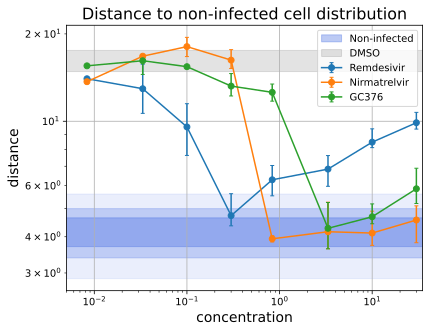

In [12]:
compounds = average_predictions.copy()

# Control drugs
drug_names = {
    'DD4386006': 'Remdesivir',
    'DO8167002': 'Nirmatrelvir', 
    'DI1202001': 'GC376',
}

# Drugs - statistics from experimental results
for drug_id, drug_name in drug_names.items():
    drug = compounds[compounds['batch_id'] == drug_id].sort_values(by=['cmpd_conc'], ascending=True)
    conc = drug['cmpd_conc'].to_numpy()
    median = drug['distance_median'].to_numpy()
    perc_25 = drug['distance_q_25'].to_numpy()
    perc_75 = drug['distance_q_75'].to_numpy()
    if drug_name.lower() != 'dmso':
        plt.errorbar(conc, median, yerr=[perc_25, perc_75], 
                     capsize=2, elinewidth=1.5, fmt='o-', label=drug_name)


# Non-infected cells - confidence intervals
non_inf = compounds[compounds['batch_id'] == 'non-inf']
conc = range(0, 40, 1)
for i, conf in enumerate([0.5, 0.75, 0.95]):
    label = "Non-infected" if i == 0 else None
    left, right = stats.chi2.interval(confidence=conf, df=n_components)
    plt.fill_between(conc, np.sqrt(left), np.sqrt(right), 
                     color='royalblue', alpha=0.5*(1-conf)**0.5, 
                     zorder=1, label=label
    )
# median = n_components * (1 - 2 / (9 * n_components))**3
# plt.plot(conc, [np.sqrt(median)] * len(conc), color='k', label='Healthy')


# DMSO
drug = compounds[compounds['batch_id'] == 'DMSO']
conc = range(0, 40, 1)
median = drug['distance_median'].to_numpy()
perc_25 = drug['distance_q_25'].to_numpy()
perc_75 = drug['distance_q_75'].to_numpy()
plt.fill_between(
    conc, median-perc_25, median+perc_75, 
    color='k', alpha=0.5*(1-conf)**0.5, 
    zorder=1, label='DMSO'
)

plt.legend()
plt.grid()
plt.xscale('log')
plt.xlabel("concentration", fontsize=14)
plt.xlim(0.5e-2, 35)

plt.yscale('log') 
plt.ylabel("distance", fontsize=14)

plt.title("Distance to non-infected cell distribution", fontsize=16)
plt.show()

Threshold for the distance


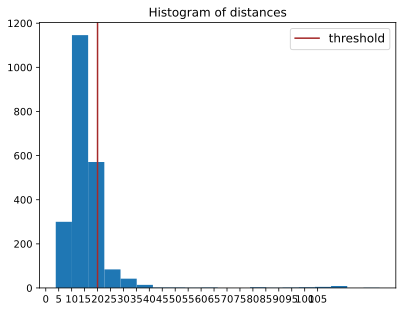

In [13]:
plt.hist(average_predictions['distance_median'], bins=20)
plt.title("Histogram of distances")
plt.axvline(20, c='brown', label='threshold')
plt.xticks(np.arange(0, 110, 5))
plt.legend(fontsize=12)
plt.show()

THRESH = 20

### Let us now look at the interactive plots

In [14]:
## Run this cell to install the library for interactive graphs

# !pip3 install plotly
# !pip3 install --upgrade nbformat

Hint: double-click on any trace to only show this particular trace and hide all others. Subsequently, you can click on the labels in the legend to switch on the traces that you want to add to the plot.


In [15]:
import plotly.express as px

def plot_compounds_interactive(compounds, dmso=None):
    drug_names = {
        id_: name_ for (id_, name_) in zip(compounds['batch_id'], compounds['name'])
    }

    drugs = compounds[~compounds['batch_id'].isin(['non-inf', 'DMSO'])]
    fig = px.line(
        drugs.sort_values(by="cmpd_conc"), x="cmpd_conc", y="distance_median",
        color='name', markers=True,
        width=1200, height=400,
        error_y='distance_q_75', error_y_minus='distance_q_75',
        category_orders={"name": drug_names.values()},
    )

    # Healthy cells - confidence intervals
    for i, conf in enumerate([0.5, 0.75, 0.95]):
        label = dict(
            text="Non-infected", font=dict(size=15, color="black"), textposition="middle left"
        ) if i == 0 else None

        left, right = stats.chi2.interval(confidence=conf, df=n_components)
        fig.add_hrect(
            type="rect",
            y0=np.sqrt(left), y1=np.sqrt(right),
            fillcolor="royalblue", opacity=0.8*(1-conf)**0.5,
            layer="below", line_width=0, label=label
        )

    # DMSO
    if dmso is not None:
        conc = range(0, 31, 1)
        median = dmso['distance_median'].iloc[0]
        perc_25 = dmso['distance_q_25'].iloc[0]
        perc_75 = dmso['distance_q_75'].iloc[0]
        fig.add_hrect(
            type="rect",
            y0=median-perc_25, y1=median+perc_75,
            fillcolor="grey", opacity=0.25,
            layer="below", line_width=0,
            label=dict(
                text="DMSO", font=dict(size=15, color="black"), textposition="middle left"
            )
        )

    conc = np.unique(compounds['cmpd_conc'])
    fig.update_xaxes(title_text="concentration", gridcolor='lightgrey', type="log", tickvals=conc)
    fig.update_yaxes(title_text="distance", gridcolor='lightgrey', type="log", tickvals=[1, 5, 10, 100])
    fig.update_layout(
        title_text="Distance to non-infected cell distribution",
        plot_bgcolor='white'
    )

    fig.show()


In [16]:
# compounds = average_predictions.copy()
compounds = average_predictions[average_predictions['distance_median'] <= THRESH].copy()
dmso = compounds[compounds['batch_id'] == 'DMSO']

plot_compounds_interactive(compounds, dmso)

#### Remove above DMSO

In [17]:
# compounds = average_predictions.copy()
dmso = compounds[compounds['batch_id'] == 'DMSO']
dmso_level = dmso['distance_median'].iloc[0]
thresh = min(THRESH, dmso_level)
compounds = average_predictions[average_predictions['distance_median'] <= thresh].copy()

plot_compounds_interactive(compounds, dmso)
len(compounds)

1403

In [21]:
# Read the type of drug: primary hit, secondary hit, or analog

subset = pd.read_csv("data/metadata_annotations.csv", usecols=["CBCSbatch_id", "arm"])
subset.rename(columns={"CBCSbatch_id": "batch_id", "arm": "type"}, inplace=True)

# Extract primary hit
primary_hit_id = subset[subset['type'] == 'primary_hit']['batch_id'].to_list()
primary_hits = compounds[compounds['batch_id'].isin(primary_hit_id)].copy()

plot_compounds_interactive(primary_hits, dmso)

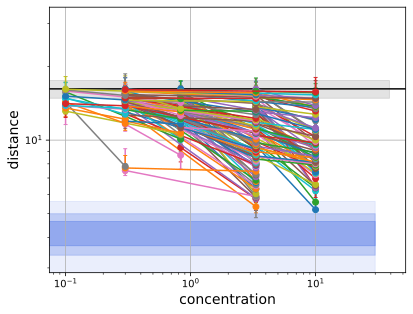

184


In [24]:
compounds = primary_hits.copy()

dmso = average_predictions[average_predictions['batch_id'] == 'DMSO'].copy()
# dmso_level = dmso['distance_median'].to_numpy() - dmso['distance_q_25'].to_numpy()
dmso_level = dmso['distance_median'].to_numpy()

THRESHOLD_FOR_BEST = dmso_level

selected_comp_and_conc = {}

drug_names = {
    id_: name_ for (id_, name_) in zip(compounds['batch_id'], compounds['name'])
}

# Drugs - statistics from experimental results
count = 0
plot_df = pd.DataFrame()
for drug_id, drug_name in drug_names.items():
    drug = compounds[compounds['batch_id'] == drug_id].sort_values(by=['cmpd_conc'], ascending=True)
    conc = drug['cmpd_conc']
    median = drug['distance_median']
    perc_25 = drug['distance_q_25']
    perc_75 = drug['distance_q_75']
    # Plot option 1: errorbars
    if drug_name.lower() in ('remdesivir', 'nirmatrelvir', 'gc376', 'non-inf'):
        continue
    if drug_id in ('DD4386002'):
        continue
    if len(conc) >= 1:
        conc_list = list(conc)
        med_list = list(median)
        perc_25_list = list(perc_25)
        perc_75_list = list(perc_75)
        min_ind = np.argmin(med_list)
        if min_ind > 0 and conc_list[min_ind] < 30 and med_list[min_ind] < THRESHOLD_FOR_BEST:
            conc_two = [conc_list[min_ind-1], conc_list[min_ind]]
            median_two = [med_list[min_ind-1], med_list[min_ind]]
            perc_25_two = [perc_25_list[min_ind-1], perc_25_list[min_ind]]
            perc_75_two = [perc_75_list[min_ind-1], perc_75_list[min_ind]]
            selected_comp_and_conc[drug_id] = conc_two
        else:
            continue
        count += 1
        plt.errorbar(conc_two, median_two, yerr=[perc_25_two, perc_75_two], 
                capsize=2, elinewidth=1.5, fmt='o-', label=drug_name)

# Healthy cells - confidence intervals
non_inf = compounds[compounds['batch_id'] == 'non-inf']
conc = range(0, 31, 1)
# median = n_components * (1 - 2 / (9 * n_components))**3
# plt.plot(conc, [np.sqrt(median)] * len(conc), color='k', label='Healthy')
for conf in [0.5, 0.75, 0.95]:
    left, right = stats.chi2.interval(confidence=conf, df=n_components)
    plt.fill_between(conc, np.sqrt(left), np.sqrt(right), 
                     color='royalblue', alpha=0.5*(1-conf)**0.5, 
                     zorder=1
                    )

# DMSO
conc = range(0, 40, 1)
median = dmso['distance_median'].to_numpy()
perc_25 = dmso['distance_q_25'].to_numpy()
perc_75 = dmso['distance_q_75'].to_numpy()
plt.fill_between(
    conc, median-perc_25, median+perc_75, 
    color='k', alpha=0.5*(1-conf)**0.5, 
    zorder=1, label='DMSO'
)

# plt.legend()
plt.grid()
plt.xscale('log')
plt.xlabel("concentration", fontsize=14)

plt.yscale('log') 
plt.ylabel("distance", fontsize=14)

plt.ylim(np.sqrt(left), 35)
plt.axhline(THRESHOLD_FOR_BEST, c='k', label='threshold')

# plt.title("W shape compounds", fontsize=16)
plt.show()

print(count)

In [80]:
from scipy.stats import qmc

num_wells = 24 * 308
num_replicates = 2
num_concentrations = 2 * 2
num_combos = int(num_wells / num_replicates / num_concentrations)

num_compounds = len(selected_comp_and_conc)

sampler = qmc.LatinHypercube(d=2, seed=1)
sample_inds = sampler.integers(l_bounds=0, u_bounds=num_compounds, n=num_combos+29)

In [81]:
num_combos

924

In [82]:
C = np.zeros((num_compounds, num_compounds))
for s in sample_inds:
    C[s[0], s[1]] += 1


remove = []
for i in range(num_compounds):
    for j in range(i):
        if C[i, j] >= 1:
            if C[j, i] >= 1:
                remove.append([j, i])
    remove.append([i, i])

print(len(remove))


sample = []
drug_ids = list(selected_comp_and_conc.keys())
for p in sample_inds:
    if list(p) not in remove:
        drug_a = drug_ids[p[0]]
        drug_b = drug_ids[p[1]]
        sample.append([drug_a, drug_b])

print(len(sample_inds), len(sample))

195
953 937


In [83]:
data = []
count = 0

for i in range(len(sample)):
    id_a = sample[i][0]
    id_b = sample[i][1]
    row = {
        'Id of drug A': id_a,
        'Id of drug B': id_b,
        'Name of drug A': id_to_name[id_a],
        'Name of drug B': id_to_name[id_b],
        'Concentrations of drug A': selected_comp_and_conc[id_a],
        'Concentrations of drug B': selected_comp_and_conc[id_b]
    }
    data.append(row)
    
combinations = pd.DataFrame(data)
combinations.index += 1
combinations.to_csv("Combinations.csv", sep=';', index=True)

In [34]:
def check_if_selected(dict_selected, batch_id, conc):
    if batch_id in dict_selected.keys():
        if conc in dict_selected[batch_id]:
            return True
    return False

primaty_hits_selected = primary_hits.copy()
primaty_hits_selected['selected'] = primaty_hits_selected.apply(
    lambda x: check_if_selected(selected_comp_and_conc, x['batch_id'], x['cmpd_conc']), axis=1
)
primaty_hits_selected = primaty_hits_selected.loc[primaty_hits_selected['selected'], :]

plot_compounds_interactive(primaty_hits_selected, dmso)